In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import KeyedVectors
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenize(text):
    return [token.text for token in nlp(text.lower())]
df['tokens'] = df['review'].apply(tokenize)

In [ ]:
glove_vectors = api.load("glove-wiki-gigaword-100")

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((len(glove_vectors.key_to_index) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(glove_vectors.key_to_index)}

for word, i in word_index.items():
    embedding_vector = glove_vectors[word] if word in glove_vectors else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
def text_to_sequence(tokens):
    return [word_index.get(word, 0) for word in tokens]

df['sequences'] = df['tokens'].apply(text_to_sequence)

In [ ]:
X_tensors = [torch.LongTensor(seq) for seq in df['sequences']]
X_padded = torch.nn.utils.rnn.pad_sequence(X_tensors, batch_first=True, padding_value=0)

y = torch.FloatTensor(df['sentiment'].values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden[-1])

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden[-1])

In [ ]:
def train_model(model, X_train, y_train, optimizer, criterion, epochs=2):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        inputs = torch.LongTensor(X_train)
        labels = torch.FloatTensor(y_train).unsqueeze(1)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

In [ ]:
input_dim = len(word_index) + 1
hidden_dim = 256
output_dim = 1

# Vanilla RNN
rnn_model = RNNModel(input_dim, embedding_dim, hidden_dim, output_dim, embedding_matrix)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(rnn_model, X_train, y_train, optimizer_rnn, criterion)

# LSTM
lstm_model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, embedding_matrix)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters())

train_model(lstm_model, X_train, y_train, optimizer_lstm, criterion)

In [ ]:
# Vanilla RNN with on-the-fly embeddings
rnn_model_on_the_fly = RNNModel(input_dim, embedding_dim, hidden_dim, output_dim, np.zeros((input_dim, embedding_dim)))
optimizer_rnn_on_the_fly = torch.optim.Adam(rnn_model_on_the_fly.parameters())

train_model(rnn_model_on_the_fly, X_train, y_train, optimizer_rnn_on_the_fly, criterion)

In [ ]:
# LSTM with on-the-fly embeddings
lstm_model_on_the_fly = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, np.zeros((input_dim, embedding_dim)))
optimizer_lstm_on_the_fly = torch.optim.Adam(lstm_model_on_the_fly.parameters())

train_model(lstm_model_on_the_fly, X_train, y_train, optimizer_lstm_on_the_fly, criterion)

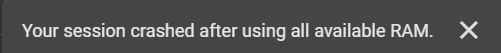

In [1]:
#the session keeps crashing for the last three cell